
<mark>**<font size=5>20240723   Test Q-learning (table-based) + Blackjack-v1 (纸牌游戏 21 点) </font>**</mark>

代码整理自： https://gymnasium.farama.org/tutorials/training_agents/blackjack_tutorial/



这里 没有设种子， 每次都不一样


<img src=attachment:86276aa4-175f-4bc3-9de1-4591c03c7c4b.png width=70% />

初始化： 初始参数向量 $w_0$， 初始策略 $\pi_0$， 小的 $\varepsilon > 0$


目标： 从 初始状态-动作对 $(s_0, a_0)$ 搜索 能让 agent 实现目标的 策略



# 环境 Blackjack-v1

* https://gymnasium.farama.org/environments/toy_text/blackjack/


<img src=attachment:0965b99d-e4d8-4105-a615-d7cc2c39fd0b.png >

Blackjack 是一种纸牌游戏，玩家的目标是通过获得比发牌者的牌总数更接近  21 (不超过 21)的牌来击败发牌者。

游戏开始时，**发牌者**有一张正面朝上的牌和一张正面朝下的牌，而**玩家**有两张正面朝上的牌。

所有的牌都是从无限的牌组中抽取的(即, 有替换)。

* 面牌Face cards  (杰克、皇后、国王 Jack, Queen, King) 的点数值为 10。
* 字母 Aces 可以算作 11 (称为 “usable ace”)，也可以算作 1。
* 数字卡 (2-9) 的值与其数字相等。

玩家拥有所持有的牌的总和。

玩家可以要求额外的牌(命中hit)，直到他们决定停止(卡住stick)或超过21(失败 bust，立即输)。

当玩家抽到牌后 sticks，发牌人拿出他们的面朝下的牌，然后抽牌，直到牌的总和等于或大于 17。

如果发牌人破产 bust 了，玩家就赢了。

如果玩家和发牌人都没有破产，那么结果(赢、输、平 win, lose, draw)就由谁的总和更接近 21 来决定。






![image.png](attachment:5faa8189-cc27-423e-972c-67dac0d41526.png)


观察结果由一个 3 元组组成，其中包含:
* 玩家当前的总和，
* 庄家的一张显示牌的值( 1-10，其中 1 为 ace)，
* 以及玩家是否持有可用的 ace(0 或 1)。


![image.png](attachment:ae45c690-a95c-4bec-aefd-938a873aa6f6.png)


![image.png](attachment:56655527-a6f6-45c5-ac69-2807b85b2765.png)


```
import gymnasium as gym
gym.make('Blackjack-v1', natural=False, sab=False)
```

`sab=False`:是否要完全遵循萨顿和巴托在书中概述的规则。

* 如果 sab 为 True，关键字参数 natural 将被忽略。
* 如果玩家获得了一个自然的 21 点，而发牌者却没有，那么玩家便会获胜(即获得 +1 奖励)。
* 相反的规则不适用。如果玩家和发牌人都得到了自然牌，那就是平局(即奖励 0)。


In [18]:
!pip install seaborn

In [19]:
!pip install gymnasium

In [20]:
# 导入 相关库
# 设置环境

from __future__ import annotations # 允许开发者在程序中声明变量或函数的类型

from collections import defaultdict

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from matplotlib.patches import Patch
from tqdm import tqdm

import gymnasium as gym

请注意，在训练循环中调用 env.render() 不是一个好主意，因为渲染会大大降低训练速度。

可以尝试在训练后建立一个额外的循环来评估和展示 代理agent。

## 创建 一个 代理 Q-learning agent

In [21]:
class BlackjackAgent:
    def __init__(
        self,
        learning_rate: float,
        initial_epsilon: float,
        epsilon_decay: float,
        final_epsilon: float,
        discount_factor: float = 0.95,
    ):
        """初始化强化学习 agent：一个 空的 状态-动作值(q_values) 字典， 学习率，ε
        参数:
            learning_rate: The learning rate  学习率
            initial_epsilon: The initial epsilon value 初始 ε 值
            epsilon_decay: The decay for epsilon   ε的衰减率
            final_epsilon: The final epsilon value  最终的 ε 值
            discount_factor: The discount factor for computing the Q-value 折扣率 γ
        """
        self.q_values = defaultdict(lambda: np.zeros(env.action_space.n))
        self.lr = learning_rate
        self.discount_factor = discount_factor

        self.epsilon = initial_epsilon
        self.epsilon_decay = epsilon_decay
        self.final_epsilon = final_epsilon

        self.training_error = []

    def get_action(self, obs: tuple[int, int, bool]) -> int:
        """
        以概率 (1-ε) 返回最佳动作
        以概率 ε 随机选择动作  以探索环境
        """
        if np.random.random() < self.epsilon: # 探索环境
            return env.action_space.sample()
        else: # 利用
            return int(np.argmax(self.q_values[obs]))

    def update(
        self,
        obs: tuple[int, int, bool],
        action: int,
        reward: float,
        terminated: bool,
        next_obs: tuple[int, int, bool],
    ):
        """更新 动作的 Q 值"""
        future_q_value = (not terminated) * np.max(self.q_values[next_obs])
        temporal_difference = (
            reward + self.discount_factor * future_q_value - self.q_values[obs][action]
        ) # 后面的 差 项
        self.q_values[obs][action] = (
            self.q_values[obs][action] + self.lr * temporal_difference
        ) # 更新
        self.training_error.append(temporal_difference)

    def decay_epsilon(self):
        self.epsilon = max(self.final_epsilon, self.epsilon - epsilon_decay) # 每次 降 epsilon_decay



![image.png](attachment:dd7a1b14-fa1c-4874-97c5-7ccd0cc2bbbe.png)

## 创建训练循环

agent 进行很多次回合， 每个回合结束更新 Q 值

In [22]:
# 超参数

learning_rate = 0.01
n_episodes = 100_000
start_epsilon = 1.0
epsilon_decay = start_epsilon / (n_episodes / 2) # 随着时间的推移减少探索
final_epsilon = 0.1

agent = BlackjackAgent(
    learning_rate = learning_rate,
    initial_epsilon = start_epsilon,
    epsilon_decay = epsilon_decay,
    final_epsilon = final_epsilon,
)

In [23]:
env = gym.make("Blackjack-v1", sab=True)

env = gym.wrappers.RecordEpisodeStatistics(env, deque_size=n_episodes) # 返回 累积奖励 和 回合长度


for episode in tqdm(range(n_episodes)):
    obs, info = env.reset()
    done = False

    # 进行 一个 回合episode
    while not done:
        action = agent.get_action(obs)
        next_obs, reward, terminated, truncated, info = env.step(action)

        # 更新 agent
        agent.update(obs, action, reward, terminated, next_obs)

        #
        done = terminated or truncated
        obs = next_obs

    agent.decay_epsilon()  # 减小 探索概率


100%|██████████| 100000/100000 [00:49<00:00, 2004.48it/s]


## 可视化 训练过程

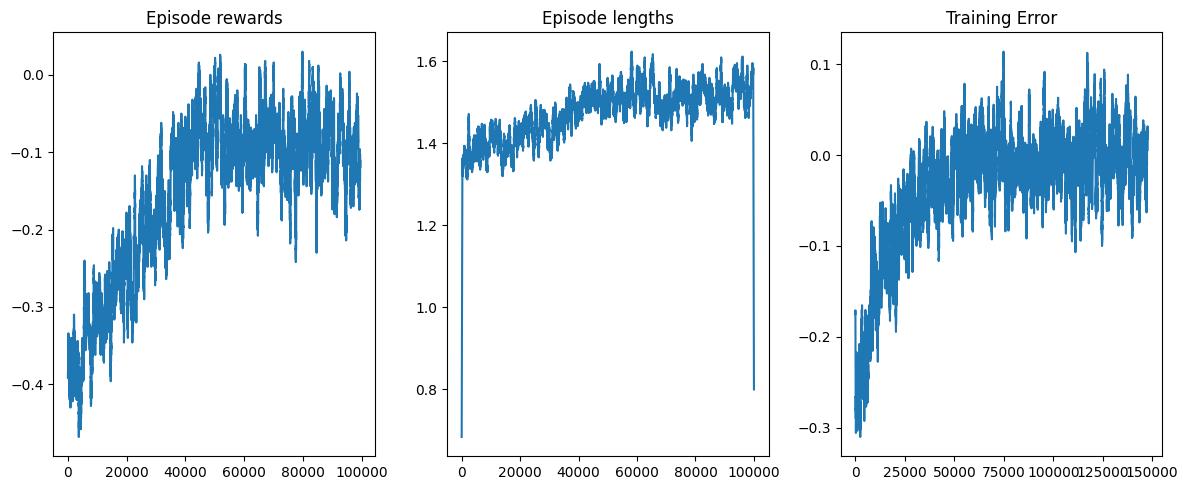

In [24]:
rolling_length = 500
fig, axs = plt.subplots(ncols=3, figsize=(12, 5))
axs[0].set_title("Episode rewards")

reward_moving_average = (
    np.convolve(
        np.array(env.return_queue).flatten(), np.ones(rolling_length), mode='valid'
    ) / rolling_length
)
axs[0].plot(range(len(reward_moving_average)), reward_moving_average)

axs[1].set_title("Episode lengths")
length_moving_average = (
    np.convolve(
        np.array(env.length_queue).flatten(), np.ones(rolling_length), mode="same"
    ) / rolling_length
)
axs[1].plot(range(len(length_moving_average)), length_moving_average)

axs[2].set_title("Training Error")
training_error_moving_average = (
    np.convolve(np.array(agent.training_error), np.ones(rolling_length), mode="same"
               ) / rolling_length
)
axs[2].plot(range(len(training_error_moving_average)), training_error_moving_average)

plt.tight_layout()
plt.show()


## 可视化 策略

In [25]:
import seaborn as sns
def create_grids(agent, usable_ace=False):
    """    创建 给定 agent 的 价值和策略 网格"""
    # 将 状态-动作 值转换为 状态值
    # 并构建一个策略字典，将观察 映射到 动作
    state_value = defaultdict(float)
    policy = defaultdict(int)
    for obs, action_values in agent.q_values.items():
        state_value[obs] = float(np.max(action_values))
        policy[obs] = int(np.argmax(action_values))

    player_count, dealer_count = np.meshgrid(
        np.arange(12, 22),
        np.arange(1, 11),
    )

    # 创建 用于 画图的 值表格
    value = np.apply_along_axis(
        lambda obs: state_value[(obs[0], obs[1], usable_ace)],
        axis=2,
        arr=np.dstack([player_count, dealer_count]),
    )
    value_grid = player_count, dealer_count, value


    # 创建 用于 画图 的 策略 grid
    policy_grid = np.apply_along_axis(
        lambda obs: policy[(obs[0], obs[1], usable_ace)],
        axis=2,
        arr=np.dstack([player_count, dealer_count]),
    )
    return value_grid, policy_grid

def create_plots(value_grid, policy_grid, title: str):
    """使用值和策略网格创建绘图。"""
    # 创建一个带有2个子图的新图(左： state values，右：policy)
    player_count, dealer_count, value = value_grid
    fig = plt.figure(figsize=plt.figaspect(0.4))
    fig.suptitle(title, fontsize=16)

    # 绘制 状态值
    ax1 = fig.add_subplot(1, 2, 1, projection="3d")
    ax1.plot_surface(
        player_count,
        dealer_count,
        value,
        rstride=1,
        cstride=1,
        cmap="viridis",
        edgecolor="none",
    )
    plt.xticks(range(12, 22), range(12, 22))
    plt.yticks(range(1, 11), ["A"] + list(range(2, 11)))
    ax1.set_title(f"State values: {title}")
    ax1.set_xlabel("Player sum")
    ax1.set_ylabel("Dealer showing")
    ax1.zaxis.set_rotate_label(False)
    ax1.set_zlabel("Value", fontsize=14, rotation=90)
    ax1.view_init(20, 220)

    # 绘制 策略
    fig.add_subplot(1, 2, 2)
    ax2 = sns.heatmap(policy_grid, linewidth=0, annot=True, cmap="Accent_r", cbar=False)
    ax2.set_title(f"Policy: {title}")
    ax2.set_xlabel("Player sum")
    ax2.set_ylabel("Dealer showing")
    ax2.set_xticklabels(range(12, 22))
    ax2.set_yticklabels(["A"] + list(range(2, 11)), fontsize=12)

    # 添加 图例 legend
    legend_elements = [
        Patch(facecolor="lightgreen", edgecolor="black", label="Hit"),
        Patch(facecolor="grey", edgecolor="black", label="Stick"),
    ]
    ax2.legend(handles=legend_elements, bbox_to_anchor=(1.3, 1))
    return fig


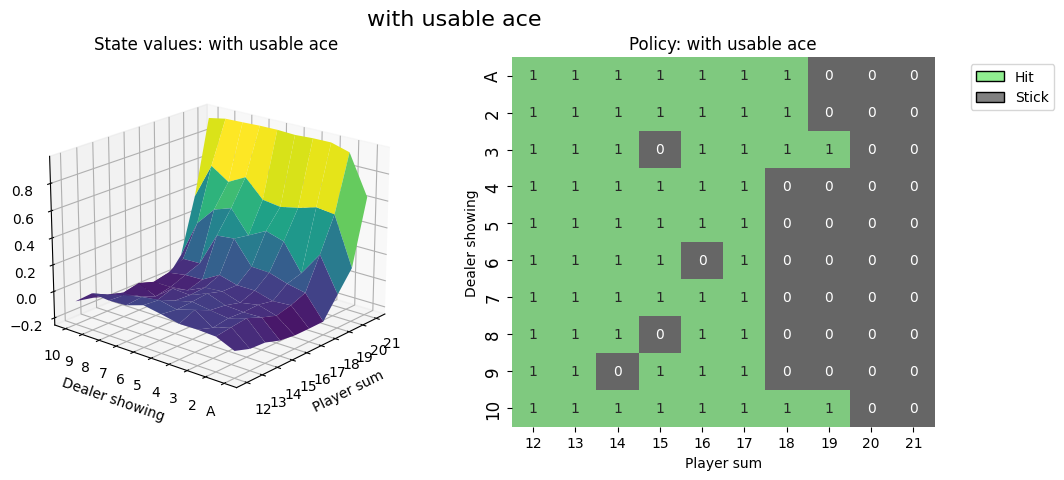

In [26]:
# 有可用 ace 的状态值和策略( ace 计数为 11)
value_grid, policy_grid = create_grids(agent, usable_ace=True)
fig1 = create_plots(value_grid, policy_grid, title="with usable ace")
plt.show()

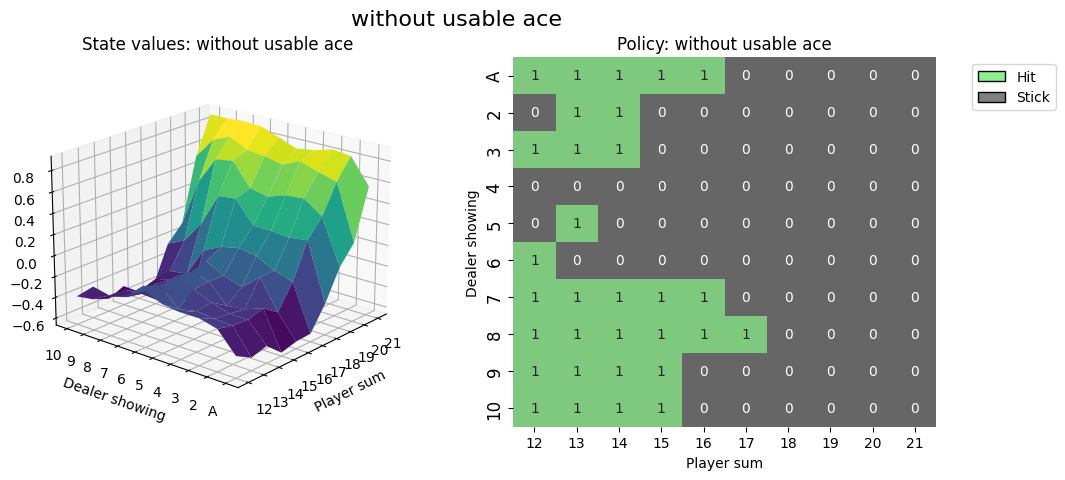

In [27]:
# 没有可用 ace 的状态值和策略( ace 计数为 1)
value_grid, policy_grid = create_grids(agent, usable_ace=False)
fig2 = create_plots(value_grid, policy_grid, title="without usable ace")
plt.show()